In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import make_filter, convolution, minimize

References and extra reading:

GLM Tutorial from Jonathan Pillow : https://github.com/pillowlab/GLMspiketraintutorial

Proof that GLMs (under certain conditions) are guaranteed to have convex loss functions : 
http://www.cns.nyu.edu/pub/lcv/paninski04b.pdf

Proof that STA is a linear estimate of the receptive field:
https://neurophysics.ucsd.edu/courses/physics_171/Chichilnisky2001.pdf


### Part 1 : Some Math
1) A statistical model for a neuron's spiking behaviour is the Poisson process. If we assume that the neuron's spike counts are drawn from a _homogenous_ Poisson process, then given a timebin of size $\Delta t$ and constant firing rate $r$, the response $y$ in a particular  timebin $t$ and trial $i$ is:

$y^i_t \sim \text{Poisson}(r\Delta t)$

a) Write down the pmf of a Poisson distribution. Use the pmf to write down the log likelihood of a spike train with $T$ timebins and $L$ trials, generated from a homogenous Poisson process as described above

b) Find the maximum likelihood (ML) estimator of $r$.

c) Repeat a) and b) for an inhomogenous Poisson process.

d) Now assume that the spikes are drawn from a 
    
    (i) Bernoulli distribution
    (ii) Gaussian distribution
    
instead of Poisson. What is the log-likelihood and ML estimator of $r$ in these 2 cases?
___

2) Now assume that the firing rate in the inhomogenous model is dependent on an input stimulus $\mathbf{x}$, via a weight vector $\boldsymbol{\omega}$ and an offset $b$.

$r_t = \omega_t x_t + b \\
 y_t \sim Poisson(r_t\Delta t)$

Write down the log likelihood for this model and its gradients with respect to $\boldsymbol{\omega}$ and $b$
___

3) We can add a nonlinearity to the model to impose constraints on the firing rate. For example, with the Poisson model, we can rewrite the firing rate $r$ as follows

$z_t = \omega_t x_t + b \\
r_t = \exp(z_t)$

to ensure that the firing rate is always positive. Enforcing this constraint via a nonlinear function means that our model in _no longer linear_, as in the previous examples. However, this model, called a Linear Nonlinear Poisson (LNP), is a _generalized_ linear model. Its likelihood is guaranteed to have a global optimum with respect to the model parameters.

a) Write down the log likelihood of the LNP model and its gradients with respect to $\boldsymbol{\omega}$ and $b$.

b) What happens if we switch to a Bernoulli model? In this model, the firing rate $r$ is actually the probability of obtaining a binary random variable (0 or 1) in a given timebin. Hence, $r$ must lie between 0 and 1. We can use the sigmod nonlinearity to enforce this constraint. Thus,

### $r_t = \frac{1}{1 + \exp(-z_t)}$

Write down the log likelihood for this model and its gradients with respect to the parameters.




---
**Solutions**

PMF of the Poisson distribution:

### $p(y) = \frac{(r\Delta t)^y \exp(-r\Delta t)}{y!}$

Likelihood of a spike train consisting of $T$ timebins and $L$ trials in a homogenous Poisson process:

In a homogenous Poisson process, we assume that the spikec ounts in each timebin and trials are _independent_, so the likelihood of a full spike train is simply the product of the probability of spike counts in each timebin and trial

### $\begin{align}
 p(y_{1:T, 1:L}) &= \prod_{t=1}^T\prod_{i=1}^L p(y^i_t)\\
 &=  \prod_{t=1}^T\prod_{i=1}^L \frac{(r\Delta t)^{y^i_t} \exp(-r\Delta t)}{y^i_t!}
\end{align}$

The log likelihood, which is the quantity we maximise to obtain the ML estimator, is:

### $ \begin{align}
\log p(y_{1:T, 1:L}) &= \sum_{t=1}^T\sum_{i=1}^L \log \frac{(r\Delta t)^{y^i_t} \exp(-r\Delta t)}{y^i_t!}\\
 &= \sum_{t=1}^T\sum_{i=1}^L y^i_t \log (r\Delta t) - r\Delta t - \log(y^i_t!)
 \end{align}$
 
The derivative of the log likelihood wrt $r$ and the ML estimator of $r$:

### $ \begin{align}
\frac{d}{dr} \log p(y_{1:T, 1:L}) &= \sum_{t=1}^T\sum_{i=1}^L (\frac{y^i_t}{r} - \Delta t) = 0\\
 &=> \frac{\sum_{t=1}^T\sum_{i=1}^L y^i_t}{r} - LT\Delta t  = 0\\
 &=> \hat{r}_{\text{ML}} = \frac{\sum_{t=1}^T\sum_{i=1}^L y^i_t}{LT\Delta t} 
 \end{align}$

___
### Part 2:   Construct a linear-nonlinear (LNP) model
So far, we have seen a linear and a linear-nonlinear model where the spike count in a given timebin is dependent only on the stimulus in that timebin. To get more realistic spike counts on the model, the firing rate should be dependent on the stimulus-history. Hence, the input stimulus to the model at each timebin is now a vector of length $K$. $K$ is number of timebins in the past during which the neuron "integrates" the effect of the stimulus, weighted by the vector $\boldsymbol{\omega}$ of size $K$:

$z_t = \sum_{k=1}^K \omega_k x_{t-k} + b$

The operation described in the equation above is called a _convolution_ and the parameter $\boldsymbol{\omega}$ is the neuron's _receptive field_.

The firing rate vector across all timebins, $\mathbf{r}$, and responses, $\mathbf{y}$, in a linear-nonlinear Poisson (LNP) process for input stimulus $\mathbf{x}$ is given by:

$\begin{align}
\mathbf{z} &= \boldsymbol{\omega} * \mathbf{x} + b \\
\mathbf{r} &= \exp(\mathbf{z}) \\
\mathbf{y} &\sim Poisson(\mathbf{r})
\end{align}$


where $\boldsymbol{\omega}$ is the convolutional filter or receptive field, $b$ is a baseline offset, $*$ is the convolution operation.  

**Questions:**

a) 
- Make a filter for this model using the make_filter() method from utils.py. You can change the parameters to get different filter shapes. You can also change the number of stimulus lags to see the effect it has on generated responses.
- Use the convolution() method from utils.py to implement the convolution step, or (optionally) try writing your own method.

b) Simulate responses $\mathbf{y}$ from this model to 200 repeats of an impulse stimulus of length "stim_lags + 1" (1 followed by 0s in all other timebins). Calculate the PSTH of these responses and use them to extract estimates of $\boldsymbol{\omega}$ and $b$

c) Simulate responses $\mathbf{y}$ from this model to 200 repeats of Gaussian white noise stimulus of length 100. Calculate the peristimulus time histogram (PSTH) of these responses and compare it to the rate $\mathbf{r}$ from the model -- the 2 should match.

d) Simulate responses from this model to Gaussian white noise input of length 1000. Calculate the spike triggered average (STA) and compare with the groundtruth $\boldsymbol{\omega}$. Do they match? Rescale the STA by its norm and compare again. Does rescaling the STA improve the estimate? Why does this happen?


___
### Note : Calculating the spike triggered average (STA)
The STA is the stimulus shape, that on average, elicits a response. It is a linear estimate of the convolution filter. To calculate the STA we average over all the stimulus vectors (of a fixed length) that preceded a timebin, and weighted by the number of spikes in that timebin. Since we already know the length of the convolution filter, the most sensible thing to do is to fix the length of the stimulus vectors at this value. However, you can try calculating the STA with other lengths. Thus:

## $\text{STA} = \frac{\sum_{t=k}^{T} \mathbf{y}_t  \mathbf{x}_{t-k\text{ }:\text{ }t}}{\sum_{t=k}^{T} \mathbf{y}_t}$

where $\mathbf{x}$ is the stimulus and $\mathbf{y}$ is the response vector and $k$ is the fixed length of the stimulus preceding a spike.

If we construct a matrix by stacking all the stimulus vectors that precede each timebin, we get a [Hankel matrix](https://en.wikipedia.org/wiki/Hankel_matrix). Look at the hankel() method in utils.py, or at the docs for a scipy.linalg.hankel() to see how this is implemented.
We can use the Hankel matrix $\mathbf{X}$ to calcualte the STA directly by matrix-vector multiplication with the response vector $\mathbf{y}$:

## $\text{STA} = \frac{1}{\sum_{t}^{T} \mathbf{y}_t}\mathbf{y}\cdot \mathbf{X} $

Note that we can also use the Hankel matrix to convert convolution operations into matrix multiplication operations.

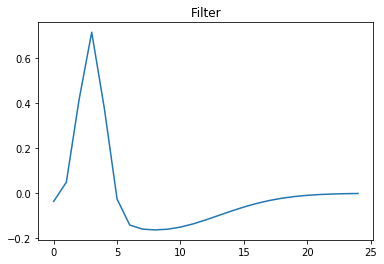

In [2]:
# a) Set the filter and baseline values
stim_lags = 25
dt = 1
_filter = make_filter(lags=stim_lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2)
baseline = 2.

plt.title("Filter")
plt.plot(_filter)
plt.show()

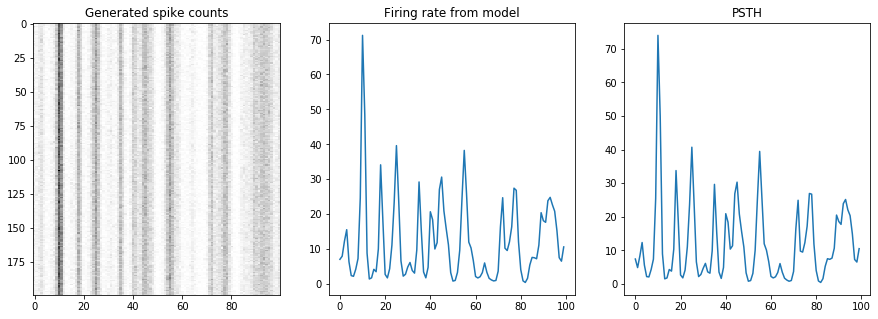

In [48]:
# c) Sample code

# Generate stimulus
stim = np.random.normal(size=100)
#Make repeats of stimulus
stim = np.tile(stim, 200).reshape(200, -1)

# Calculate firing rate
z = convolution(_filter, stim) + baseline
r = np.exp(z)
# Simulate from model
y = np.random.poisson(dt * r)

# Plot spike counts, predicted firing rate and PSTH
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title("Generated spike counts")
ax1.imshow(y, cmap='binary', aspect='auto')

ax2.set_title("Firing rate from model")
ax2.plot(r[0])

ax3.set_title("PSTH")
ax3.plot(y.mean(0))
plt.show()


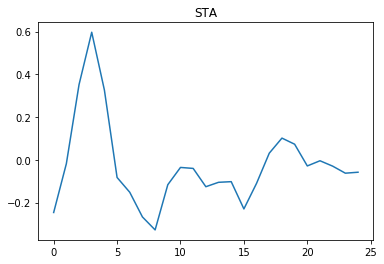

In [49]:
# Calculate STA

# Slow version:
sta = np.zeros(stim_lags)
for t, yy in enumerate(y[:, stim_lags:].T):
    sta += yy.dot(stim[:, t:t+stim_lags][:, ::-1])
sta = sta / y.sum()

# Fast version
from utils import hankel
X = hankel(stim_lags, stim)
sta = y.flatten().dot(X) / y.sum()    

plt.title("STA")
plt.plot(sta)
plt.show()

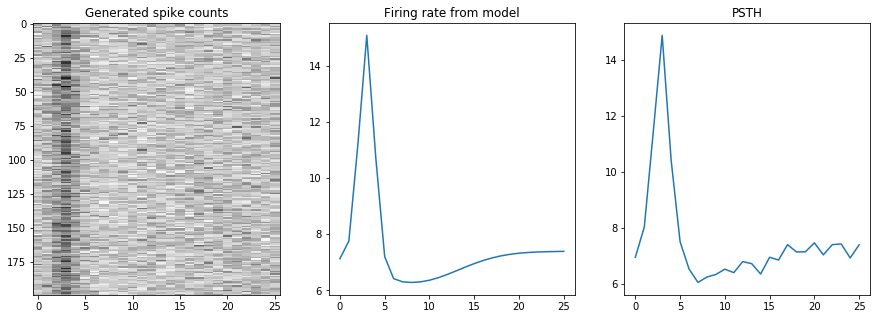

In [31]:
# Your code here:
# b) Simulate responses  𝐲  from this model to 200 repeats of an impulse stimulus of length "stim_lags + 1" 
# (1 followed by 0s in all other timebins). Calculate the PSTH of these responses and use them to extract 
# estimates of  𝝎  and  𝑏 

stim = np.zeros(stim_lags+1)
stim[0]=1
#Make repeats of stimulus
stim = np.tile(stim, 200).reshape(200, -1)

# Calculate firing rate
z = convolution(_filter, stim) + baseline

estimate_b = z[0,-1]
estimate_filter = z[0,0:-1]

r = np.exp(z)
y = np.random.poisson(dt * r)

psth = y.mean(0) # estimate of r

# Plot spike counts, predicted firing rate and PSTH
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title("Generated spike counts")
ax1.imshow(y, cmap='binary', aspect='auto')

ax2.set_title("Firing rate from model")
ax2.plot(r[0])

ax3.set_title("PSTH")
ax3.plot(psth)
plt.show()


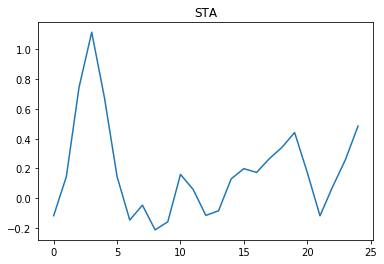

In [50]:
# d) Simulate responses from this model to Gaussian white noise input of length 1000. Calculate the spike triggered average (STA)
# and compare with the groundtruth  𝝎 . Do they match? Rescale the STA by its norm and compare again. Does rescaling the STA
# improve the estimate? Why does this happen?

# Generate stimulus
stim = np.random.normal(size=100)
#Make repeats of stimulus
stim = np.tile(stim, 200).reshape(200, -1)
# Calculate firing rate
z = convolution(_filter, stim) + baseline
r = np.exp(z)
# Simulate from model
y = np.random.poisson(dt * r)

# Fast version
from utils import hankel
X = hankel(stim_lags, stim)
sta = y.flatten().dot(X) / y.sum()    

plt.title("STA")
plt.plot(sta)
plt.show()

### Part 2.5 (Optional) : Construct a spike-history dependent LNP model

For generating even more realistic spike counts from the model, the firing rate should also depend on the spike-history. Thus, at every timebin, the model should also receive as input, its own previous spikes (a vector of length $N$), weighted by the vector $\mathbf{h}$ of size $N$:


$\begin{align}
r_t &= exp(\sum_{k=1}^K \omega_k x_{t-k} + \sum_{n=1}^N h_n y_{t-n} +  b)\\
y_t &\sim \text{Poisson}(r\Delta t)
\end{align}$

Algorithmically, this means that we can only generate spikes sequentially, rather than all at once, as in the previous examples. 

a) Repeat steps a) and c) from Part 2 for this model

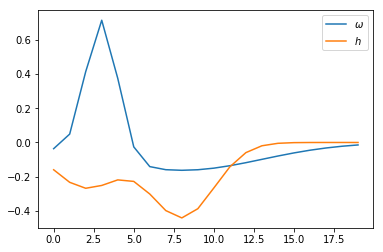

In [6]:
# Sample code

# Make filters for ω and h, set baseline
stim_lags = 20
hst_lags = 20
baseline = 2
dt = 1
_filter_w = make_filter(lags=stim_lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2)
_filter_h = - make_filter(lags=hst_lags, mu1=8., mu2=2., s1=2., s2=2., eta=-.6)

plt.plot(_filter_w, label='$\omega$')
plt.plot(_filter_h, label='$h$')
plt.legend()

In [7]:
# Generate stimulus

stim = np.random.normal(size=100)
stim = np.tile(stim, 200).reshape(200, -1)

In [8]:
# Calculate response

y = np.zeros_like(stim)
r = np.zeros_like(stim)

for i in range(stim.shape[0]):
    
    for t in range(stim.shape[1]):
        
        # calculate receptive field filter
        rf = 0
        for k in range(stim_lags):
            rf += _filter_w[k] * stim[i, t - k]
            
        # calculate spike history dependent filter
        hst = 0
        for n in range(hst_lags):
            hst += _filter_h[n] * y[i, t - n]
            
        # Calculate firing rate
        r[i, t] = np.exp(rf + hst + baseline)
        
        # Calculate response
        y[i, t] = np.random.poisson(dt * r[i, t])

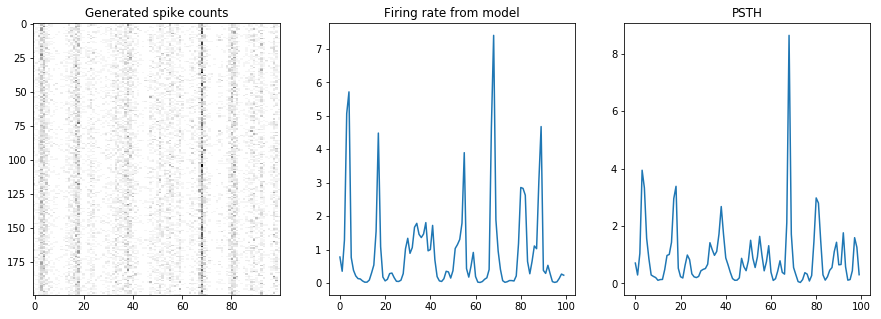

In [9]:
# Plot spike counts, predicted firing rate and PSTH
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title("Generated spike counts")
ax1.imshow(y, cmap='binary', aspect='auto')

ax2.set_title("Firing rate from model")
ax2.plot(r[0])

ax3.set_title("PSTH")
ax3.plot(y.mean(0))
plt.show()

In [10]:
# Your code here


### Part 3:   Fitting an LNP model with maximum likelihood estimation (MLE)

We can write down the likelihood of a GLM and use this to estimate the parameters that best fit a given dataset. If the nonlinearity in the GLM increases monotonically and the outputs of the GLM are drawn from the exponential family distribution, then the likelihood (and therefore, the log likelihood) is guaranteed to be concave and have a single global optimum with respect to the GLM parameters.

For an LNP model with a parameters $\boldsymbol{\omega}$, the predicted firing rate, assuming the canonical $\exp()$ nonlinearity, is given by:

$\mathbf{r}_t = \exp(\boldsymbol{\omega} * \mathbf{x}_{t-k\text{ }:\text{ }t})$

and the samples are drawn from a Poisson distribution parameterized by $\mathbf{r}$. Note that we assume that the spike count in each time bin is _conditionally independent_ i.e. the spike count in every timebin is assumed to be independent of the counts in the other timebins, given the stimulus history for that particular timebin.

Given predetermined inputs $\mathbf{x}$ and groundtruth responses $\mathbf{y}^{\text{real}}$, the likelihood in a particular timebin is given by the pmf of the Poisson distribution:

### $P(\mathbf{y}^{\text{real}}_t | \boldsymbol{\omega}, \mathbf{x}_{t-k\text{ }:\text{ }t}) = \frac{\mathbf{r}_t^{\mathbf{y}^{\text{real}}_t}}{\mathbf{y}^{\text{real}}_t!}\exp(-\mathbf{r}_t)$

Since we assume that the responses are conditionally independent, we can simply multiply the likelihood across all timebins, to get the likelihood of the full spike train.


### $P(\mathbf{y}^{\text{real}} | \boldsymbol{\omega}, \mathbf{x}) = \prod_t^T P(\mathbf{y}^{\text{real}}_t | \boldsymbol{\omega}, \mathbf{x}_{t-k\text{ }:\text{ }t})$

We maximise the log of this quantity to get the maximum likelihood estimate of the parameters.

### $\boldsymbol{\omega}^* = \text{argmax}_{\boldsymbol{\omega}} \log P(\mathbf{y}^{\text{real}} | \boldsymbol{\omega}, \mathbf{x})$

**Questions:**

a) Using a fixed filter and baseline, simulate responses $\mathbf{y}^{real}$ from an LNP model, as in Part 2. Save the response and stimulus values -- these will be our groundtruth (real) dataset.

b) Calculate the STA for these responses

c) Write down a Python function that takes as input the LNP parameters (filter and baseline), the groundtruth stimulus and the groundtruth responses, and returns the log likelihood of the model.
(Hint : check your function against the cost() method in utils.py)

d) Get the MLE estimate of the parameters using the minimize() method from utils.py

e) Compare the MLE estimate of the filter to the STA and the true filter. 

f) Simulate data from the LNP model, using the 
1. the STA estimate and the baseline esitmated from the mean firing rate 
2. the MLE estimate of the parameters

Compare the mean and variance of the spike trains from 1. and 2. with that of the real spike trains.

g) _Optional_: How do things change if we now switch to a Bernoulli model of the spike trains? Replace the nonlinearity in the LNP model with a sigmoid, and sample from a Bernoulli distribution instead of a Poisson distribution. Write down the log likelihood of this model. Repeats steps (a) - (f) for this model

In [11]:
# Sample code

# Make filter, set baseline

# a) Set the filter and baseline values
stim_lags = 25
dt = 1
_filter = make_filter(lags=stim_lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2)
baseline = 2.

# Generate stimulus and responses

# Generate stimulus
stim = np.random.normal(size=100)

#Make repeats of stimulus
stim = np.tile(stim, 200).reshape(200, -1)

# Calculate firing rate
z = convolution(_filter, stim) + baseline
r = np.exp(z)
# Simulate from model
y = np.random.poisson(dt * r)


# Call minimize() from utils.py to get MLE estimates

w_est, b_est = minimize(stim, y, stim_lags, dt)

In [12]:
# Your code here:



